# Árvores II - Cross Validation II

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [2]:
X_train = pd.read_csv('X_train_novo.csv', index_col=['index','individuo'])
y_train = pd.read_csv('y_train_novo.csv',index_col='Unnamed: 0')

X_test = pd.read_csv('X_test_novo.csv', index_col=['index','individuo'])
y_test = pd.read_csv('y_test_novo.csv',index_col='Unnamed: 0')

### 2. Calcule os ```ccp_alphas```. 


- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis"

In [13]:
SEED = 1729
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.25, random_state=SEED)

In [14]:
SEED = 1729
caminho = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20,
                                 random_state=SEED).cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha).fit(X_train,y_train)
    clfs.append(clf)

In [15]:
train_scores = [clf.score(X_train,y_train) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 93.18


DecisionTreeClassifier(random_state=1729)

In [16]:
importance = ({"feature": list(X_train.columns),
               "importance": melhor_arvore.feature_importances_})

importance_clf = pd.DataFrame(importance).sort_values("importance", ascending=False)
importance_clf.head(3)

,feature,importance
52,53 tGravityAcc-min()-X,0.219909
265,266 fBodyAcc-mean()-X,0.202716
41,42 tGravityAcc-mean()-Y,0.135141


In [20]:
x_train =X_train.iloc[:,importance_clf[0:3].index]
x_valid = X_valid.iloc[:,importance_clf[0:3].index]

caminho = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20,
                                 random_state=SEED).cost_complexity_pruning_path(x_train,y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=SEED, ccp_alpha=ccp_alpha).fit(x_train,y_train)
    clfs.append(clf)
    
train_scores = [clf.score(x_train,y_train) for clf in clfs]
valid_scores = [clf.score(x_valid, y_valid) for clf in clfs]

ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 87.53


DecisionTreeClassifier(ccp_alpha=0.0019005960266067316, random_state=1729)

### 3. *Grid Search*

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [21]:
%%time

grid_param = {'ccp_alpha':ccp_alphas}

grid = GridSearchCV(estimator = melhor_arvore, param_grid=grid_param, 
                    cv = 10)
grid.fit(X_train,y_train)

CPU times: total: 3min 41s
Wall time: 3min 42s


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0019005960266067316,
                                              random_state=1729),
             param_grid={'ccp_alpha': array([0.        , 0.0019006 , 0.00718094, 0.00746207, 0.04740741,
       0.07359347, 0.11179106, 0.16840866, 0.1826912 ])})

In [22]:
resultados = pd.DataFrame(grid.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.534084,0.263541,0.006848,0.003545,0.0,{'ccp_alpha': 0.0},0.942029,0.932367,0.939614,0.917874,0.944444,0.900726,0.934625,0.927361,0.907990,0.905569,0.925260,0.015298,2
1,2.451722,0.191117,0.007208,0.003069,0.001901,{'ccp_alpha': 0.0019005960266067316},0.944444,0.929952,0.927536,0.932367,0.954106,0.915254,0.934625,0.927361,0.915254,0.924939,0.930584,0.011344,1
2,2.364979,0.265531,0.007742,0.005624,0.007181,{'ccp_alpha': 0.00718094474620129},0.932367,0.915459,0.903382,0.888889,0.939614,0.907990,0.920097,0.893462,0.895884,0.888620,0.908576,0.017065,3
3,2.726800,0.249327,0.009342,0.004526,0.007462,{'ccp_alpha': 0.007462070524526878},0.932367,0.915459,0.903382,0.888889,0.929952,0.905569,0.920097,0.891041,0.891041,0.888620,0.906642,0.016132,4
4,2.534507,0.244355,0.005988,0.002852,0.047407,{'ccp_alpha': 0.04740741243325547},0.896135,0.893720,0.893720,0.862319,0.910628,0.871671,0.898305,0.859564,0.866828,0.847458,0.880035,0.019855,5
5,2.360664,0.187638,0.008610,0.005999,0.073593,{'ccp_alpha': 0.07359346859657476},0.896135,0.893720,0.893720,0.862319,0.910628,0.871671,0.898305,0.859564,0.866828,0.847458,0.880035,0.019855,5
6,2.287088,0.180598,0.008472,0.006160,0.111791,{'ccp_alpha': 0.11179106090886329},0.548309,0.545894,0.543478,0.661836,0.545894,0.547215,0.547215,0.547215,0.658596,0.668281,0.581393,0.053421,7
7,2.353598,0.217195,0.007738,0.006308,0.168409,{'ccp_alpha': 0.16840865532178284},0.548309,0.545894,0.371981,0.371981,0.545894,0.375303,0.375303,0.375303,0.375303,0.375303,0.426057,0.078991,8
8,2.310678,0.136648,0.007252,0.006644,0.182691,{'ccp_alpha': 0.1826911966850756},0.188406,0.185990,0.371981,0.371981,0.371981,0.375303,0.375303,0.375303,0.375303,0.375303,0.336685,0.074759,9


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

In [24]:
melhor_ccp = resultados.iloc[grid.best_index_,4]
clf_final = DecisionTreeClassifier(random_state=SEED, ccp_alpha=melhor_ccp).fit(X_train,y_train)

clf_final.score(X_test, y_test)

0.8720732948761453

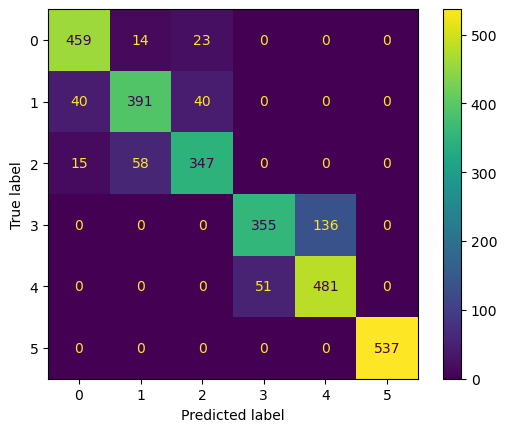

In [65]:
predictions = clf_final.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [53]:
y_train_dummies = pd.get_dummies(y_train['0'])
y_train_cut = y_train_dummies[4].to_frame()
y_train_cut.head()

,4
5579,0
3093,1
1705,0
4177,0
5573,0


In [55]:
clf_4 = DecisionTreeClassifier(random_state=100, min_samples_leaf = 20, 
                             max_depth = 4).fit(X_train, y_train_cut)


importance_clf = pd.Series(clf_4.feature_importances_, index = X_train.columns)
importance_clf.sort_values(ascending = False, inplace = True)
importance_clf.head(3)

41 tGravityAcc-mean()-X     0.468560
560 angle(Y,gravityMean)    0.293797
430 fBodyGyro-mad()-X       0.155650
dtype: float64

In [62]:
x_train_4 =X_train[['41 tGravityAcc-mean()-X', '560 angle(Y,gravityMean)', '430 fBodyGyro-mad()-X']]
x_test_4 = X_test[['41 tGravityAcc-mean()-X', '560 angle(Y,gravityMean)', '430 fBodyGyro-mad()-X']]

caminho = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20,
                                 random_state=SEED).cost_complexity_pruning_path(x_train_4,y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

In [64]:
%%time
clf_4 = DecisionTreeClassifier(random_state=100, min_samples_leaf = 20, 
                             max_depth = 4).fit(x_train_4, y_train)

grid = GridSearchCV(estimator = clf_4, param_grid={'ccp_alpha':ccp_alphas}
                    ,cv=10)
grid.fit(x_train_4, y_train)

results = pd.DataFrame(grid.cv_results_)
results.head()

CPU times: total: 1.03 s
Wall time: 1.02 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008360,0.007159,0.002162,0.004640,0.0,{'ccp_alpha': 0.0},0.804348,0.797101,0.775362,0.753623,0.775362,0.796610,0.801453,0.769976,0.767554,0.762712,0.780410,0.017067,1
1,0.009374,0.007654,0.000000,0.000000,0.001427,{'ccp_alpha': 0.0014269788627663225},0.804348,0.797101,0.775362,0.753623,0.775362,0.796610,0.801453,0.769976,0.767554,0.762712,0.780410,0.017067,1
2,0.007812,0.007812,0.001562,0.004687,0.002625,{'ccp_alpha': 0.0026254444160935045},0.809179,0.794686,0.765700,0.753623,0.777778,0.796610,0.799031,0.779661,0.762712,0.762712,0.780169,0.017911,3
3,0.006565,0.007236,0.002264,0.004582,0.007321,{'ccp_alpha': 0.007321461253738296},0.809179,0.794686,0.765700,0.753623,0.777778,0.794189,0.796610,0.779661,0.762712,0.762712,0.779685,0.017454,4
4,0.007867,0.006876,0.001960,0.004616,0.018928,{'ccp_alpha': 0.01892841054338304},0.777778,0.794686,0.765700,0.712560,0.777778,0.750605,0.757869,0.738499,0.719128,0.762712,0.755732,0.024837,5


In [66]:
melhor_ccp = results.iloc[grid.best_index_,4]
clf_final = DecisionTreeClassifier(random_state=SEED, 
                                   ccp_alpha=melhor_ccp).fit(x_train_4, y_train)

clf_final.score(x_test_4, y_test)

0.6745843230403801

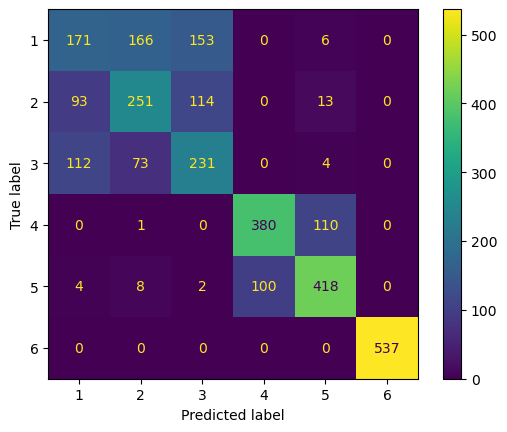

In [67]:
ConfusionMatrixDisplay.from_estimator(clf_final, x_test_4, y_test);

Apesar do modelo anterior possuir acurácia geral maior, se desejarmos um modelo apenas para a classe 4 este último acaba sendo melhor que o anterior.